# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [46]:
df = pd.read_csv('worldcities.csv')
df.head()

,city_name,latitude,longitude,country,population
0,Tokyo,35.6897,139.6922,Japan,37977000.0
1,Jakarta,-6.2146,106.8451,Indonesia,34540000.0
2,Delhi,28.6600,77.2300,India,29617000.0
3,Mumbai,18.9667,72.8333,India,23355000.0
4,Manila,14.6000,120.9833,Philippines,23088000.0


In [47]:
df.describe(include='all')

,city_name,latitude,longitude,country,population
count,41001,41001.000000,41001.000000,41001,4.026300e+04
unique,37499,NaN,NaN,237,NaN
top,Springfield,NaN,NaN,United States,NaN
freq,17,NaN,NaN,7824,NaN
mean,NaN,30.909850,-4.228119,NaN,1.117614e+05
std,NaN,23.504898,68.759032,NaN,7.248917e+05
min,NaN,-54.934100,-179.590000,NaN,0.000000e+00
25%,NaN,19.190300,-71.850000,NaN,8.194000e+03
50%,NaN,39.885400,3.333300,NaN,1.583100e+04
75%,NaN,47.371700,25.983300,NaN,3.982350e+04


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41001 entries, 0 to 41000
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city_name   41001 non-null  object 
 1   latitude    41001 non-null  float64
 2   longitude   41001 non-null  float64
 3   country     41001 non-null  object 
 4   population  40263 non-null  float64
dtypes: float64(3), object(2)
memory usage: 1.6+ MB


In [52]:
df.isnull().sum()

city_name       0
latitude        0
longitude       0
country         0
population    738
dtype: int64

In [56]:
df['population'] = df['population'].fillna(df['population'].mean())

In [57]:
df.isnull().sum()

city_name     0
latitude      0
longitude     0
country       0
population    0
dtype: int64

In [58]:
Q1 = df_clean.quantile(0.25)
Q3 = df_clean.quantile(0.75)
IQR = Q3 - Q1

# Tentukan batas outlier
outlier_mask = (df_clean < (Q1 - 1.5 * IQR)) | (df_clean > (Q3 + 1.5 * IQR))

# Tampilkan jumlah outlier per kolom
outlier_mask.sum()

Index    0
dtype: int64

# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

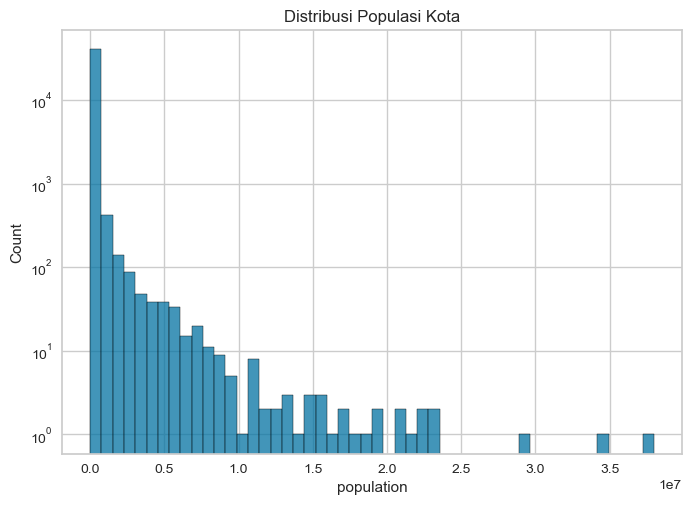

In [59]:
sns.histplot(df['population'], bins=50, log_scale=(False, True))
plt.title("Distribusi Populasi Kota")
plt.show()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah.

In [62]:
data = df[['latitude', 'longitude', 'population']].dropna()

In [64]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [68]:
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(scaled_data)
df['cluster'] = labels

## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

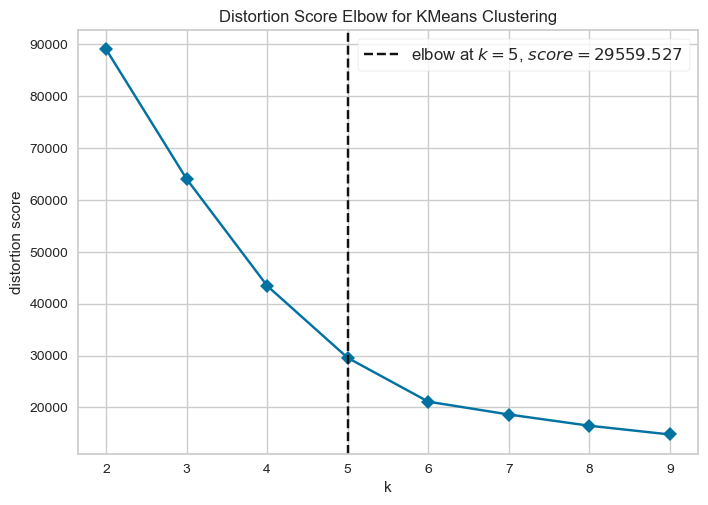

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [76]:
model = KMeans(random_state=42, n_init=10)
elbow_visualizer = KElbowVisualizer(model, k=(2, 10), metric='distortion', timings=False)
elbow_visualizer.fit(scaled_data)
elbow_visualizer.show()

In [77]:
silhouette_avg = silhouette_score(scaled_data,labels)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.5977670611283651


## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [44]:
#Type your code here

## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

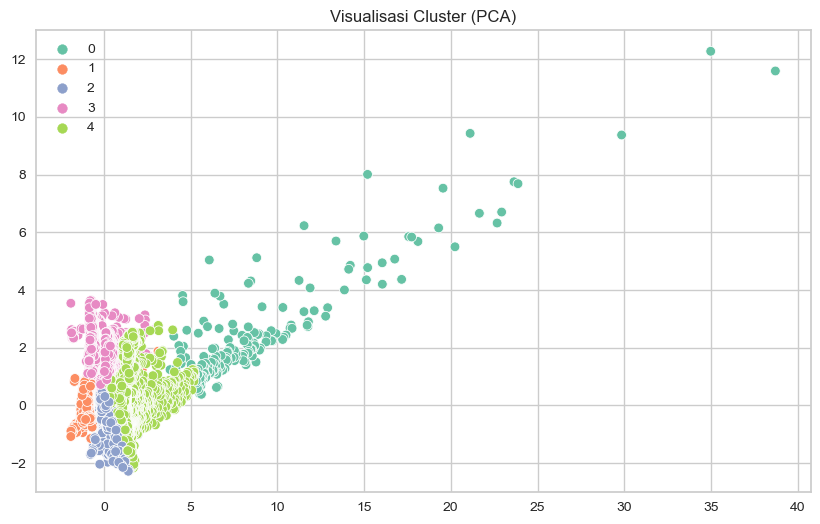

In [71]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled_data)
plt.figure(figsize=(10,6))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=clusters, palette='Set2')
plt.title("Visualisasi Cluster (PCA)")
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

### Interpretasi Target

**Tutorial: Melakukan Inverse Transform pada Data Target Setelah Clustering**

Setelah melakukan clustering dengan model **KMeans**, kita perlu mengembalikan data yang telah diubah (normalisasi, standarisasi, atau label encoding) ke bentuk aslinya. Berikut adalah langkah-langkahnya.

---

**1. Tambahkan Hasil Label Cluster ke DataFrame**
Setelah mendapatkan hasil clustering, kita tambahkan label cluster ke dalam DataFrame yang telah dinormalisasi.

```python
df_normalized['Cluster'] = model_kmeans.labels_
```

Lakukan Inverse Transform pada feature yang sudah dilakukan Labelisasi dan Standararisasi. Berikut code untuk melakukannya:
label_encoder.inverse_transform(X_Selected[['Fitur']])

Lalu masukkan ke dalam kolom dataset asli atau membuat dataframe baru
```python
df_normalized['Fitur'] = label_encoder.inverse_transform(df_normalized[['Fitur']])
```
Masukkan Data yang Sudah Di-Inverse ke dalam Dataset Asli atau Buat DataFrame Baru
```python
df_original['Fitur'] = df_normalized['Fitur']
```

### Inverse Data Jika Melakukan Normalisasi/Standardisasi

Inverse Transform untuk Data yang Distandarisasi
Jika data numerik telah dinormalisasi menggunakan StandardScaler atau MinMaxScaler, kita bisa mengembalikannya ke skala asli:
```python
df_normalized[['Fitur_Numerik']] = scaler.inverse_transform(df_normalized[['Fitur_Numerik']])
```

In [78]:
df_normalized = scaler.inverse_transform(scaled_data)


Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

Tulis hasil interpretasinya di sini.
1. Cluster 0 : Menunjukkan bahwa cluster ini mencakup kota-kota dengan variasi populasi yang tinggi dan juga penyebaran geografis yang luas.
2. Cluster 1 : Kemungkinan cluster ini adalah kota regional atau pinggiran, tidak terlalu padat atau ekstrim secara posisi.
3. Cluster 2 : Menunjukkan Kota-kota di sini mungkin memiliki kepadatan lebih rendah
4. Cluster 3 : Kota-kota di cluster ini mungkin punya populasi lebih tinggi daripada cluster 1 & 2, tapi masih jauh lebih rendah dibanding cluster 0. Bisa jadi mewakili kota-kota menengah ke atas
5. Cluster 4 : Kota-kota dengan populasi menengah, tidak terlalu besar maupun kecil.


# Contoh interpretasi [TEMPLATE]
# Analisis Karakteristik Cluster dari Model KMeans

Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan dari model KMeans.

## Cluster 1:
- **Rata-rata Annual Income (k$):** 48,260  
- **Rata-rata Spending Score (1-100):** 56.48  
- **Analisis:** Cluster ini mencakup pelanggan dengan pendapatan tahunan menengah dan tingkat pengeluaran yang cukup tinggi. Pelanggan dalam cluster ini cenderung memiliki daya beli yang moderat dan mereka lebih cenderung untuk membelanjakan sebagian besar pendapatan mereka.

## Cluster 2:
- **Rata-rata Annual Income (k$):** 86,540  
- **Rata-rata Spending Score (1-100):** 82.13  
- **Analisis:** Cluster ini menunjukkan pelanggan dengan pendapatan tahunan tinggi dan pengeluaran yang sangat tinggi. Pelanggan di cluster ini merupakan kelompok premium dengan daya beli yang kuat dan cenderung mengeluarkan uang dalam jumlah besar untuk produk atau layanan.

## Cluster 3:
- **Rata-rata Annual Income (k$):** 87,000  
- **Rata-rata Spending Score (1-100):** 18.63  
- **Analisis:** Cluster ini terdiri dari pelanggan dengan pendapatan tahunan yang tinggi tetapi pengeluaran yang rendah. Mereka mungkin memiliki kapasitas finansial yang baik namun tidak terlalu aktif dalam berbelanja. Ini bisa menunjukkan bahwa mereka lebih selektif dalam pengeluaran mereka atau mungkin lebih cenderung untuk menyimpan uang.

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [79]:
df.to_csv("hasil_clustering.csv", index=False)